In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("zoheb/sketch-scene", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/9999 [00:00<?, ? examples/s]

In [ ]:
dataset[0]["text"]

'giraffe is eating leaves from the tree'

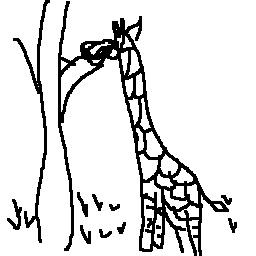

In [ ]:
dataset[0]["image"]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()


trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


In [ ]:
import random
from torch.utils.data import Dataset, DataLoader


num_samples = 6000


random_indices = random.sample(range(len(dataset)), num_samples)


selected_dataset = [dataset[idx] for idx in random_indices]

train_dataset = ImageCaptioningDataset(selected_dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=60, collate_fn=collate_fn)


all_indices = list(range(len(dataset)))


nonselected_indices = list(set(all_indices) - set(random_indices))


nonselected_dataset = [dataset[idx] for idx in nonselected_indices]

random.shuffle(nonselected_indices)
val_indices = nonselected_indices[:1000]
selected_val_dataset = [dataset[idx] for idx in val_indices]
test_indices = nonselected_indices[1000:2000]
selected_test_dataset = [dataset[idx] for idx in test_indices]

val_dataset = ImageCaptioningDataset(selected_val_dataset, processor)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=60, collate_fn=collate_fn)

test_dataset = ImageCaptioningDataset(selected_test_dataset, processor)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=60, collate_fn=collate_fn)

In [ ]:
import torch
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) #5e-4 #2e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
model.train()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(5):
    print("Epoch:", epoch)
    epoch_train_loss = 0.0
    correct = 0
    total = 0
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, torch.float16)


        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss

        print("Train Loss:", loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_train_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 2)
        total += input_ids.size(0) * input_ids.size(1)
        correct += (predicted == input_ids).sum().item()

    train_loss = epoch_train_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)




    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device, torch.float16)

            val_outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels = input_ids)

            loss = val_outputs.loss
            val_loss += loss.item()

            _, val_predicted = torch.max(val_outputs.logits, 2)
            total_val += input_ids.size(0) * input_ids.size(1)
            correct_val += (val_predicted == input_ids).sum().item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print("Validation Loss:", avg_val_loss)
    print("Validation Accuracy:", val_accuracy)


print("Done!")

model.save_pretrained("blip2_finetuning")

Epoch: 0
Train Loss: 8.1875
Train Loss: 8.2890625
Train Loss: 8.3125
Train Loss: 8.203125
Train Loss: 8.1015625
Train Loss: 7.5625
Train Loss: 7.87890625
Train Loss: 8.1875
Train Loss: 8.09375
Train Loss: 8.15625
Train Loss: 8.265625
Train Loss: 7.96484375
Train Loss: 7.859375
Train Loss: 8.203125
Train Loss: 7.97265625
Train Loss: 7.86328125
Train Loss: 7.88671875
Train Loss: 8.0859375
Train Loss: 7.85546875
Train Loss: 7.80859375
Train Loss: 8.0
Train Loss: 7.91796875
Train Loss: 7.77734375
Train Loss: 7.859375
Train Loss: 7.92578125
Train Loss: 7.94140625
Train Loss: 7.83984375
Train Loss: 7.89453125
Train Loss: 7.96484375
Train Loss: 7.99609375
Train Loss: 7.8359375
Train Loss: 7.453125
Train Loss: 7.53125
Train Loss: 7.65625
Train Loss: 7.2265625
Train Loss: 7.71875
Train Loss: 7.40234375
Train Loss: 7.61328125
Train Loss: 7.49609375
Train Loss: 7.48046875
Train Loss: 7.5625
Train Loss: 7.32421875
Train Loss: 7.21875
Train Loss: 7.26171875
Train Loss: 7.37890625
Train Loss: 7.3906

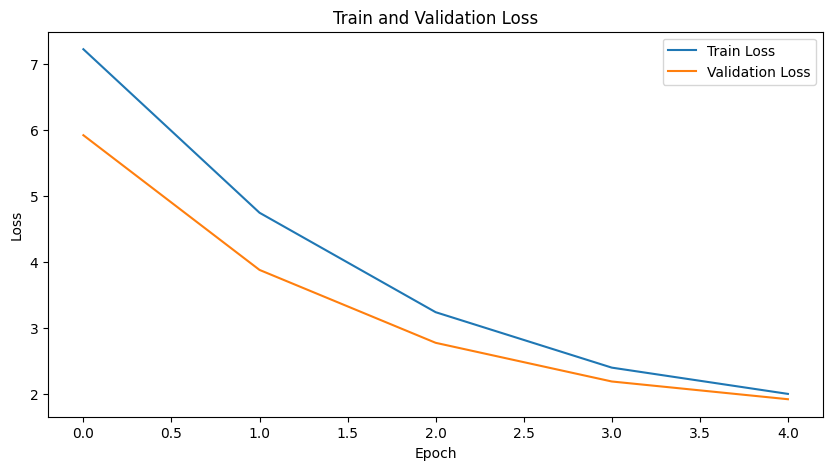

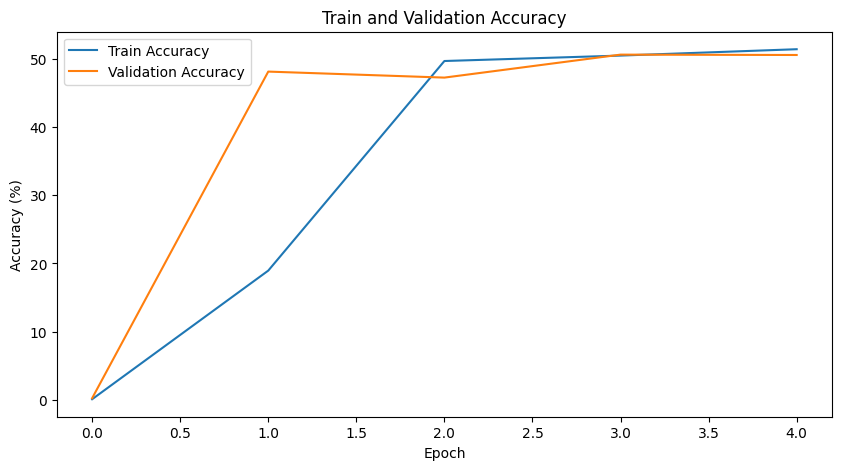

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")  # 훈련 정확도 그래프
plt.plot(val_accuracies, label="Validation Accuracy")  # 검증 정확도 그래프
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.show()


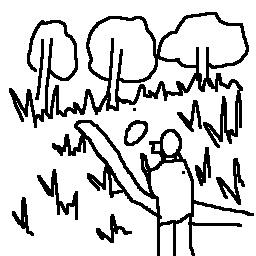

In [ ]:
example = dataset[random.choice(test_indices)]
image = example["image"]
image

In [ ]:
import os
from PIL import Image
image = Image.open("/content/drive/MyDrive/customdataset/KakaoTalk_20230821_035436690.jpg")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a cartoon drawing of a man holding balloons



In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer.push_to_hub()

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)